## Movies for vorticity - Can we see CTWs?

In [1]:
#KRM
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
#from MITgcmutils import rdmds # not working
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import seaborn as sns
import xarray as xr
import canyon_tools.readout_tools as rout

In [2]:
CanyonGrid='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
grid = xr.open_dataset(CanyonGrid)

CanyonState='/data/kramosmu/results/TracerExperiments/CNTDIFF/run38/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)
state = xr.open_dataset(CanyonState)

In [3]:
# General input
nx = 616
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
Time = CanyonStateOut.variables['T']

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells
yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacW = rout.getField(CanyonGrid, 'HFacW') # (Z,Y,Xp1) for zonal fluxes
MaskW = rout.getMask(CanyonGrid,'HFacW') 

hFacS = rout.getField(CanyonGrid, 'HFacS') # (Z,Yp1,X) for meridional fluxes
MaskS = rout.getMask(CanyonGrid,'HFacS') 

In [4]:
import matplotlib.animation as animation

In [35]:
sns.set_style('ticks')
sns.set_context("notebook")
spdcmap = cmo.cm.delta

In [6]:
def rel_vort(x,y,u,v):
    """-----------------------------------------------------------------------------
    rel_vort calculates the z component of relative vorticity.
    
    INPUT:
    x,y,u,v should be at least 2D arrays in coordinate order (..., Y , X ) 
    
    OUTPUT:
    relvort - z-relative vorticity array of size u[...,2:-2,2:-2]
    -----------------------------------------------------------------------------"""
    dvdx = (v[...,1:-1, 3:]-v[...,1:-1, :-3])/(x[...,1:-1, 2:]-x[...,1:-1, :-2])
    dudy = (u[...,3:, 1:-1]-u[..., :-3,1:-1])/(y[..., 2:,1:-1]-y[..., :-2,1:-1])
    relvort = dvdx - dudy
    return relvort

In [90]:
def Plot1(t,ax1):    
    sns.despine(ax=ax1)
     # Load velocity components
    uu = state.U.isel(Z=zslice1, T=t)
    vv = state.V.isel(Z=zslice1, T=t)

    U,V = rout.unstagger(uu.data,vv.data)
   
    uplane = np.ma.array(U[200:-120,1:180],mask=MaskC[zslice1,200:-120,1:180])
    vplane = np.ma.array(V[1+200:-120,0:180],mask=MaskC[zslice1,1+200:-120,0:180])
    vort = rel_vort(xc[1+200:-120,1:180],yc[1+200:-120,1:180],uplane,vplane)
    
    csSpd = np.linspace(-2,8,num=40)
    ax1.clear()
    mesh=ax1.contourf(xc[2+200:-120-1,2:-1+180]/1000,yc[2+200:-1-120,2:-1+180]/1000,vort[:,:]/1e-4,csSpd,cmap=spdcmap)
    if t == 1:
        cbar=plt.colorbar(mesh,ax=ax1, format='%1.1f')
    ax1.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax1.set_xticks([5,10,15,20,25,30,35,40,45,50,55,60])
    ax1.set_xlabel('Alongshelf distance [km]')
    ax1.set_ylabel('Cross-shelf distance [km]')
    ax1.set_title('Relative vorticity at %0.2f m , day %0.1f' %(z[zslice1], (t/2.0)))
    return(ax1,mesh)


In [8]:
def PlotSurf(t,ax1):    
    
     # Load velocity components
    uu = state.U.isel(Z=zslice1, T=t)
    vv = state.V.isel(Z=zslice1, T=t)

    U,V = rout.unstagger(uu.data,vv.data)
   
    uplane = np.ma.array(U[:,1:615],mask=MaskC[zslice1,:,1:615])
    vplane = np.ma.array(V[1:,:615],mask=MaskC[zslice1,1:,:615])
    vort = rel_vort(xc[1:,1:615],yc[1:,1:615],uplane,vplane)
    
    csSpd = np.linspace(-2,5,num=35)
    ax1.clear()
    mesh=ax1.contourf(xc[2:-1,2:-1+615]/1000,yc[2:-1,2:-1+615]/1000,vort[:,:]/1e-4,csSpd,cmap=spdcmap)
    if t == 1:
        cbar=plt.colorbar(mesh,ax=ax1, format='%1.1f')
    #ax1.text(287,-5,r'[$10^{-4}$ s$^{-1}$]') 
    ax1.set_axis_bgcolor((205/255.0, 201/255.0, 201/255.0))
    ax1.set_xlabel('Alongshelf distance [km]')
    ax1.set_ylabel('Cross-shelf distance [km]')
    ax1.set_title('Relative vorticity at %0.2f m , day %0.1f' %(z[zslice1], (t/2.0)))



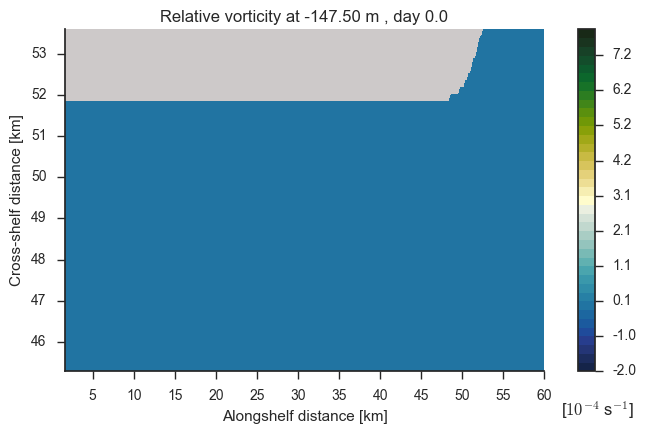

In [46]:
## Animation

zslice1= 29 # shelf break index

#Empty figures
fig, ax1= plt.subplots(1, 1, figsize=(7, 4.5))
ax1.set_aspect(5)

#Initial image
def init():
    Plot1(0,ax1)
    
    
    plt.tight_layout()
    

def animate(tt):
    ax1,mesh = Plot1(tt,ax1)
    plt.tight_layout()
    ax1.text(62,44.2,r'[$10^{-4}$ s$^{-1}$]') 
   
Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=19,repeat=False)

## Save in current folder

anim.save('CNTDIFF_Vort_CTW_Hs.mp4', writer=writer)

plt.show()



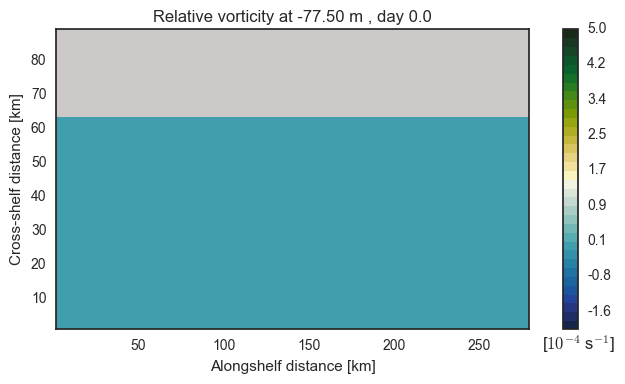

In [154]:
## Animation

zslice1= 15 # shelf break index

#Empty figures
fig, ax1= plt.subplots(1, 1, figsize=(7, 4))
ax1.set_aspect(2)

#Initial image
def init():
    PlotSurf(0,ax1)
    
    
    plt.tight_layout()
    

def animate(tt):
    PlotSurf(tt,ax1)
    plt.tight_layout()

Writer = animation.writers['ffmpeg']
writer = Writer(fps=1, metadata=dict(artist='Me'), bitrate=1800)


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=19,repeat=False)

## Save in current folder

anim.save('CNTDIFF_Vort_CTW_WholeDom_z15.mp4', writer=writer)

plt.show()



## Plots

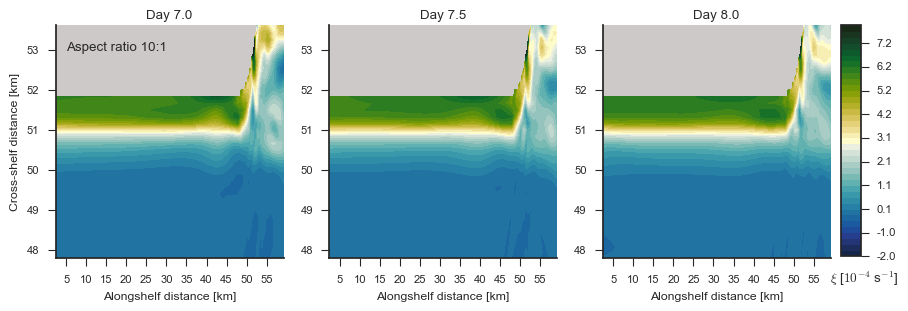

In [111]:
sns.set_context('paper')
zslice1= 29 # shelf break index

#Empty figure
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax1.set_aspect(10)
ax2.set_aspect(10)
ax3.set_aspect(10)

ax1, mesh1 = Plot1(14,ax1)
ax2, mesh2 = Plot1(15,ax2)
ax3, mesh3 =Plot1(16,ax3)

ax2.set_ylabel('')
ax3.set_ylabel('')
ax3.text(59,47.2,r'$\xi$ [$10^{-4}$ s$^{-1}$]') 
ax1.text(5,53,'Aspect ratio 10:1') 
   
ax1.set_title('Day 7.0')    
ax2.set_title('Day 7.5')    
ax3.set_title('Day 8.0')    

cb = fig.add_axes([0.91, 0.13, 0.02, 0.77]) 
CB = plt.colorbar(mesh3, cax=cb, format='%1.1f')
#plt.tight_layout()

plt.savefig('Vort_wave_day7.eps',format='eps',bbox_inches='tight')

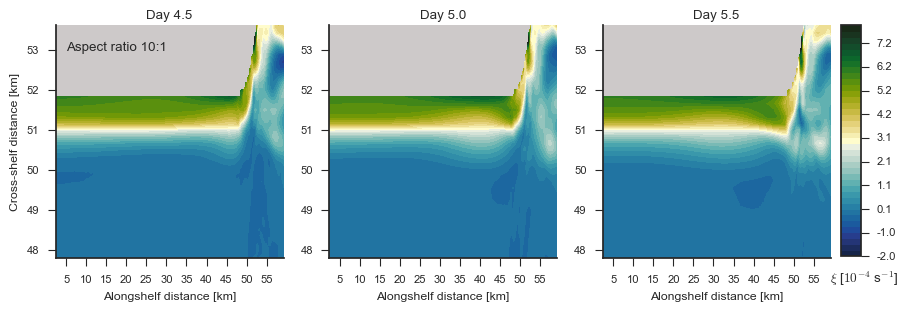

In [110]:
sns.set_context('paper')
zslice1= 29 # shelf break index

#Empty figure
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax1.set_aspect(10)
ax2.set_aspect(10)
ax3.set_aspect(10)

ax1, mesh1 = Plot1(9,ax1)
ax2, mesh2 = Plot1(10,ax2)
ax3, mesh3 =Plot1(11,ax3)

ax2.set_ylabel('')
ax3.set_ylabel('')
ax3.text(59,47.2,r'$\xi$ [$10^{-4}$ s$^{-1}$]') 
ax1.text(5,53,'Aspect ratio 10:1') 
   
ax1.set_title('Day 4.5')    
ax2.set_title('Day 5.0')    
ax3.set_title('Day 5.5')    

cb = fig.add_axes([0.91, 0.13, 0.02, 0.77]) 
CB = plt.colorbar(mesh3, cax=cb, format='%1.1f')
#plt.tight_layout()

plt.savefig('Vort_wave_day4p5.eps',format='eps',bbox_inches='tight')